# Landscape Area Measurements for Urban Outdoor Water Budgets

This notebook performs a land cover classification for a single NAIP tile using RandomForest. 

## Imports and directory setup

In [1]:
# Import packages
import os

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import json
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.crs import CRS
from rasterio.plot import plotting_extent
import contextily as cx
from shapely.geometry import Polygon, shape, mapping
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Set directory
if os.path.exists(os.path.join(et.io.HOME, 'git', 'landscape-area-measurements')):
    os.chdir(os.path.join(et.io.HOME, 'git', 'landscape-area-measurements'))
else:
    os.makedirs(os.path.join(et.io.HOME, 'git', 'landscape-area-measurements'))
    os.chdir(os.path.join(et.io.HOME, 'git', 'landscape-area-measurements'))

from lam_functions import (clean_array_plot,
                           get_cii_parcel_polygons,
                           mask_and_fill)

## Import NAIP tile
Test tile is included in data folder. 

In [2]:
# Open NAIP file
tile_path = os.path.join('data',
                         'naip',
                         'm_3311815_se_11_060_20200505',
                         'm_3311815_se_11_060_20200505.tif')

naip_tile = rxr.open_rasterio(tile_path)

# Define bounds of test tile and create polygon of tile footprint
tile_bounds = naip_tile.rio.bounds()

lat_point_list = [tile_bounds[1], tile_bounds[1],
                  tile_bounds[3], tile_bounds[3]]
lon_point_list = [tile_bounds[0], tile_bounds[2],
                  tile_bounds[2], tile_bounds[0]]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = naip_tile.rio.crs
tile_polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

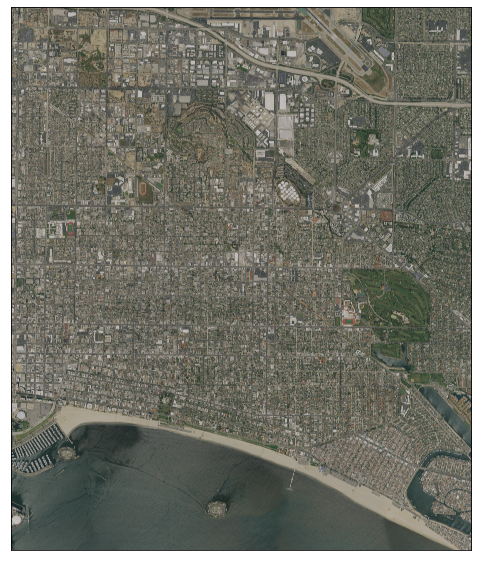

In [3]:
tile_extent = plotting_extent(naip_tile[0],
                              naip_tile.rio.transform())

fig, ax = plt.subplots(figsize=(12,10))

ep.plot_rgb(clean_array_plot(naip_tile),
            rgb=[0, 1, 2],
            ax=ax, 
            extent=tile_extent)

plt.show()

## Overlaying commercial parcel boundaries

The function get_cii_parcel_polygons is written for LA County Parcel Data API. 

In [4]:
# Get CII parcels for extent of NAIP tile, reproject, and clip
cii_gdf_plot = get_cii_parcel_polygons(naip_tile)

cii_gdf_plot_reproj = cii_gdf_plot.to_crs(epsg=26911).reset_index()

cii_plot_clip = gpd.clip(cii_gdf_plot_reproj, tile_polygon)

Text(0.5, 1.0, 'CII parcel boundaries in test tile area')

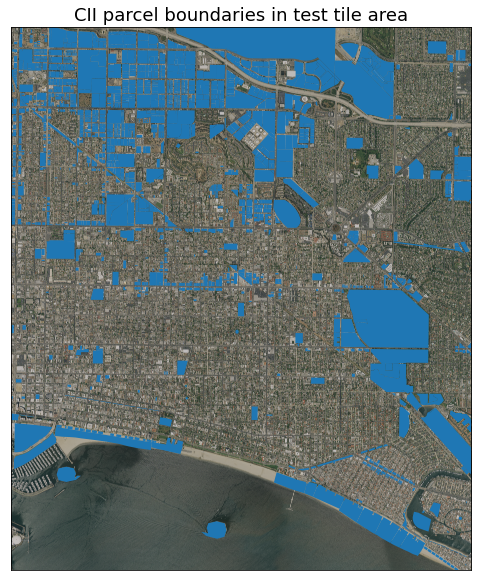

In [5]:
tile_extent = plotting_extent(naip_tile[0],
                              naip_tile.rio.transform())

fig, ax = plt.subplots(figsize=(12,10))

ep.plot_rgb(clean_array_plot(naip_tile),
            rgb=[0, 1, 2],
            ax=ax, 
            extent=tile_extent)

cii_plot_clip.plot(ax=ax)

ax.set_title('CII parcel boundaries in test tile area', 
             fontsize=18)

## Calculate NDVI and NDWI

NDVI and NDWI are used as input features to the RandomForest model, in addition to the 4 NAIP bands. 

A mask is applied to both NDVI and NDWI to exclude erroneous values. 

In [6]:
# Calculate NDVI for tile
ndvi_tile = (naip_tile[3]-naip_tile[2]) / (naip_tile[3]+naip_tile[2])

Text(0.5, 1.05, 'NDVI of NAIP tile area near Long Beach, CA (before masking water)')

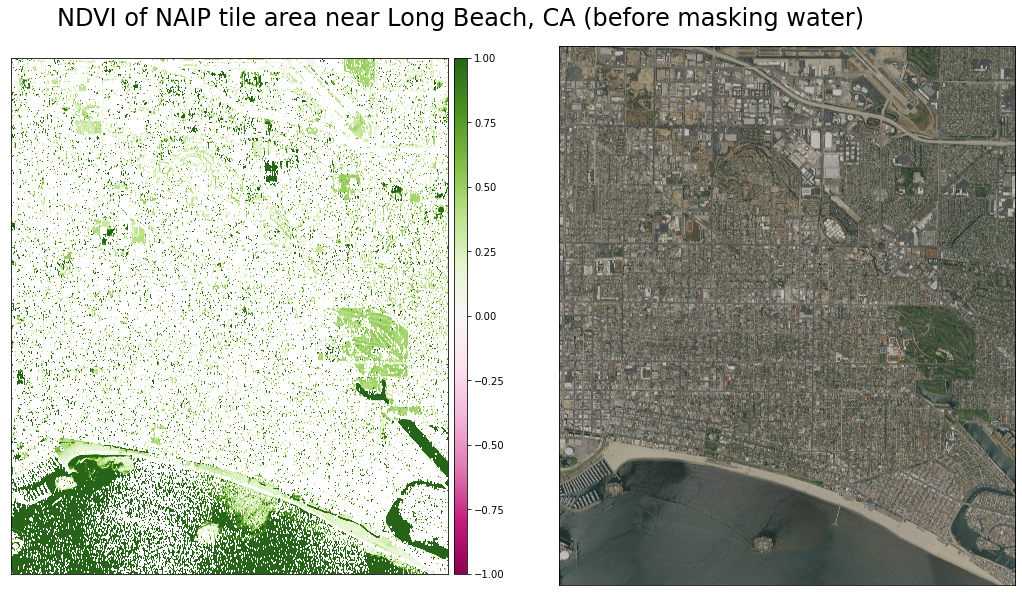

In [7]:
# Plot NDVI and tile imagery
tile_extent = plotting_extent(naip_tile[0],
                              naip_tile.rio.transform())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 15))

ep.plot_bands(ndvi_tile,
              ax=ax1,
              cmap='PiYG',
              scale=False,
              vmin=-1,
              vmax=1,
              extent=tile_extent)

ep.plot_rgb(clean_array_plot(naip_tile),
            rgb=[0, 1, 2],
            ax=ax2,
            extent=tile_extent)

plt.title('NDVI of NAIP tile area near Long Beach, CA (before masking water)',
          fontsize=24,
          y=1.05)

Text(0.5, 1.0, 'Masked NDVI of NAIP tile area near Long Beach, CA')

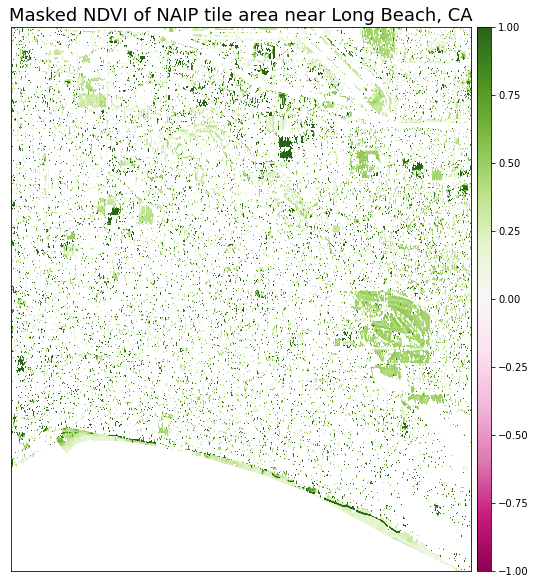

In [8]:
# Mask out waterways using vector mask
ndvi_mask_path = os.path.join('data',
                              'mask',
                              'water_mask_2.shp')

ndvi_mask = gpd.read_file(ndvi_mask_path)

masked_ndvi = ndvi_tile.rio.clip(ndvi_mask.geometry.apply(mapping),
                                 drop=False,
                                 invert=True)

# Plot masked data
fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(masked_ndvi,
              ax=ax,
              cmap='PiYG',
              scale=False,
              vmin=-1,
              vmax=1,
              extent=tile_extent)
ax.set_title('Masked NDVI of NAIP tile area near Long Beach, CA',
             fontsize=18)

Text(0.5, 1.05, 'NDWI of NAIP tile area near Long Beach, CA (before masking land)')

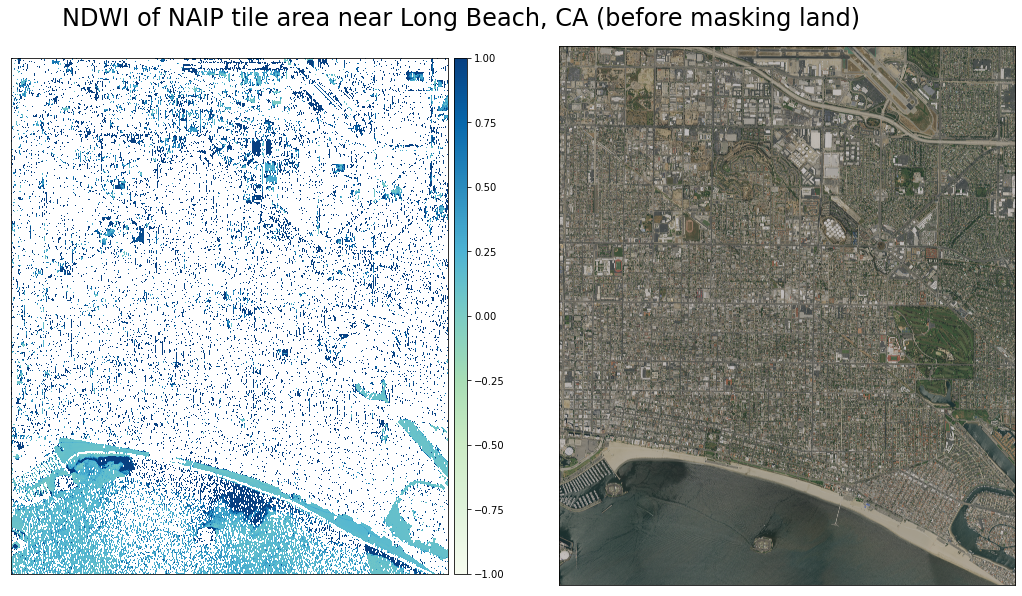

In [9]:
# Calculate NDWI and plot
ndwi_tile = (naip_tile[1]-naip_tile[3]) / (naip_tile[1]+naip_tile[3])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 15))

ep.plot_bands(ndwi_tile,
              ax=ax1,
              cmap='GnBu',
              scale=False,
              vmin=-1,
              vmax=1,
              extent=tile_extent)
ep.plot_rgb(clean_array_plot(naip_tile),
            rgb=[0, 1, 2],
            ax=ax2,
            extent=tile_extent)

plt.title('NDWI of NAIP tile area near Long Beach, CA (before masking land)',
             fontsize=24, 
          y=1.05)

Text(0.5, 1.0, 'Masked NDWI of NAIP tile area near Long Beach, CA')

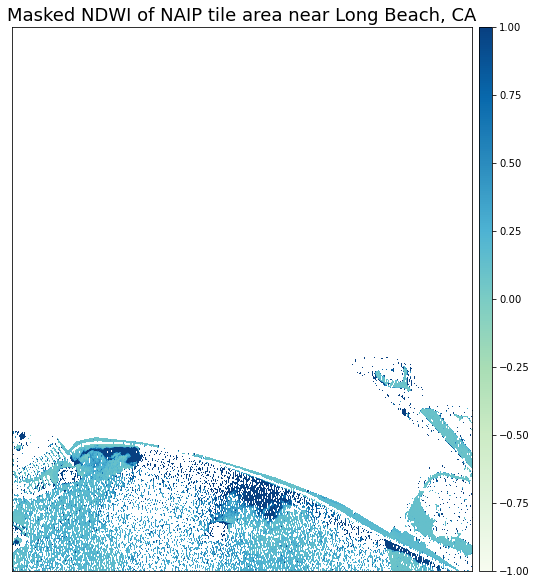

In [10]:
# Apply NDWI mask 
ndwi_mask_path = os.path.join('data', 
                              'mask',
                              'ndwi_mask_1.shp')

ndwi_mask = gpd.read_file(ndwi_mask_path)


masked_ndwi = ndwi_tile.rio.clip(ndwi_mask.geometry.apply(mapping),
                                 drop=False, 
                                 invert=True)

fig, ax = plt.subplots(figsize=(10,10))

ep.plot_bands(masked_ndwi,
              ax=ax,
              cmap='GnBu',
              scale=False,
              vmin=-1,
              vmax=1,
              extent=tile_extent)

ax.set_title('Masked NDWI of NAIP tile area near Long Beach, CA',
             fontsize=18)

## Import training data

Training data were manually created in ArcGIS Pro. The polygon features were exported as a raster, so that the cell sizes and locations of the rasterized polygons aligned with the NAIP imagery.

In [11]:
# Open training data
training_raster_path = os.path.join('data',
                                    'training',
                                    'training_se_3.tif')
training_ras = rxr.open_rasterio(training_raster_path,
                                 masked=True).squeeze()

# Check to make sure training raster is same size as NAIP tile, then clip
if ((training_ras.shape[0] == naip_tile.shape[1]) & (training_ras.shape[1] == naip_tile.shape[2])):
    print(training_ras.shape, naip_tile.shape)
else:
    training_ras = training_ras.rio.clip(tile_polygon.geometry)

In [12]:
training_classes = ["Vegetation", 
                    "Water", 
                    "Other"]

classes_colors = ["limegreen", 
                  "darkblue", 
                  "lightgrey"]

cmap = ListedColormap(classes_colors)

Text(0.5, 1.0, 'Training data')

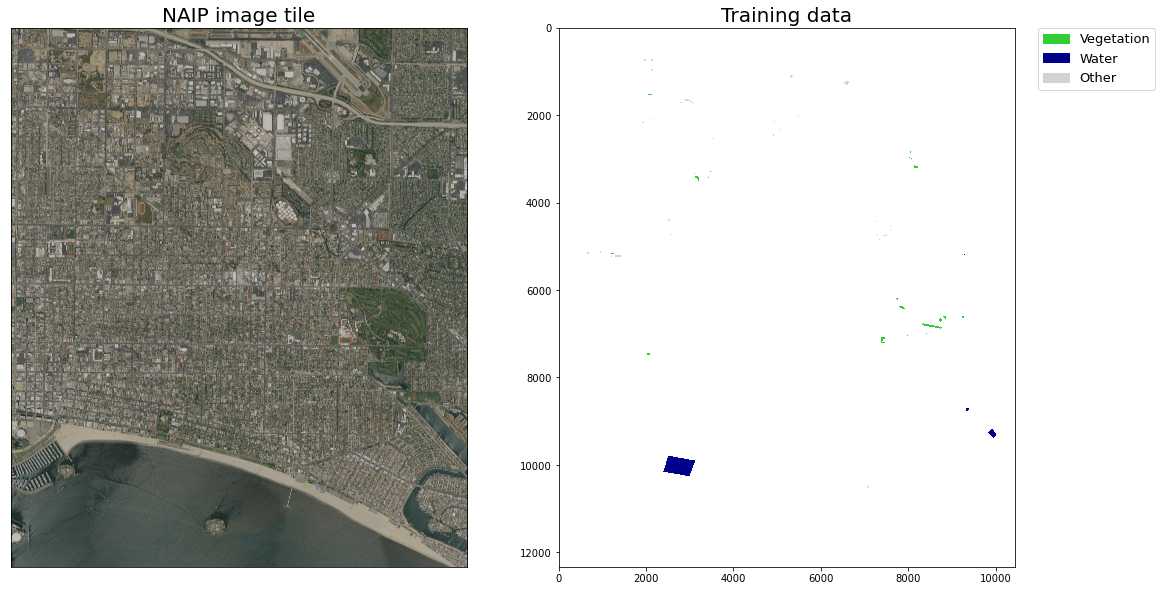

In [13]:
f, (ax1, ax2)= plt.subplots(1, 2, figsize=(18,12))

ep.plot_rgb(naip_tile.values,
            rgb=[0, 1, 2],
            ax=ax1)
im = ax2.imshow(training_ras.values,
               cmap=cmap,
               interpolation='none')
ep.draw_legend(im_ax=im,
               titles=training_classes)

ax1.set_title("NAIP image tile", 
              fontsize=20)
ax2.set_title("Training data", 
              fontsize=20)

## Stack feature arrays and initialize classifier

In [14]:
# Fill nan values in masked indices with 0 and stack with NAIP bands
ndvi_tile_0 = mask_and_fill(masked_ndvi, (-1,1), 0)
ndwi_tile_0 = mask_and_fill(masked_ndwi, (-1,1), 0)

# Stack NDVI and NDWI
stacked_indices_m_0 = xr.concat([ndvi_tile_0, ndwi_tile_0], dim=pd.Index([5, 6], name='band'))

# Stack all 
stacked_m_all_0 = xr.concat([naip_tile, stacked_indices_m_0], dim='band')

In [15]:
# Get ndarrays from DataArrays
training_arr = training_ras.values
naip_arr = stacked_m_all_0.values

In [16]:
# Check number of training samples in data
n_samples = (training_arr>0).sum()
print('You have {} total training samples (or pixels).'.format(n_samples))

You have 372772 total training samples (or pixels).


In [17]:
# Check number of classes in training data
labels = np.unique(training_arr[training_arr > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size,
                                                                classes=labels))

The training data include 3 classes: [1. 2. 3.]


In [18]:
# Count number of training pixels in each class
pix_counts = training_ras.groupby(training_ras).count().values

unique_values = np.unique(training_ras.values)
unique_values = unique_values[~np.isnan(unique_values)]

training_counts = pd.DataFrame({'vals': unique_values,
                                    'counts': pix_counts})
training_counts

vals  counts
0   1.0   69343
1   2.0  256882
2   3.0   46547

In [19]:
# Create "X" matrix which contains features, and "y" array which contains labels
# These will have n_samples rows
X = naip_arr[:, training_arr > 0]
y = training_arr[training_arr > 0]

print('The shape of our X array: {}'.format(X.shape))
print('The shape of our y array: {}'.format(y.shape))

The shape of our X array: (6, 372772)
The shape of our y array: (372772,)


In [20]:
# Transpose data so they have the same dim1
X = X.transpose()
X.shape, y.shape

((372772, 6), (372772,))

In [21]:
# Create a pairplot to explore separability of classes by band combinations
all_bands = pd.DataFrame(data=X, 
                         columns=[1, 2, 3, 4, 5, 6])
all_bands["class"] = y
all_bands

1      2      3      4         5    6  class
0       135.0  120.0   96.0  130.0  0.150442  0.0    3.0
1       135.0  121.0   96.0  131.0  0.154185  0.0    3.0
2       136.0  121.0   94.0  132.0  0.168142  0.0    3.0
3       136.0  121.0   95.0  133.0  0.166667  0.0    3.0
4       138.0  121.0   95.0  134.0  0.170306  0.0    3.0
...       ...    ...    ...    ...       ...  ...    ...
372767   93.0  106.0  143.0  136.0  0.000000  0.0    3.0
372768   93.0  105.0  144.0  136.0  0.000000  0.0    3.0
372769   89.0  103.0  140.0  134.0  0.000000  0.0    3.0
372770   92.0  105.0  145.0  138.0  0.000000  0.0    3.0
372771   94.0  105.0  144.0  137.0  0.000000  0.0    3.0

[372772 rows x 7 columns]

In [22]:
# sns.set(font_scale=1.5)
# # Create pair plot for only NAIP bands 
# sns.pairplot(all_bands[[1,2,3,4,'class']],
#              height=5,
#              plot_kws={"s": 100},
#              hue="class")
# plt.show()

In [23]:
# # Plot subset of pixel spectral signatures by class
# f, axs = plt.subplots(1, 3, figsize=(16, 6), 
#                       sharey=True)
# for group, df in all_bands[[1,2,3,4,'class']].groupby("class"):
#     the_group = int(group-1)
#     axs_ravel = axs.ravel()
#     flipped = df.T[0:500]
#     # Remove class row
#     flipped.drop(flipped.tail(1).index, inplace=True)
#     flipped.plot(color=classes_colors[the_group],
#                  ax=axs_ravel[the_group],
#                  legend=False, title=training_classes[the_group])
    
# plt.xticks(np.arange(1, 5, 1.0))
# plt.suptitle("Spectral Signatures")
# plt.show()

## Train model on all training data

In [24]:
# Initialize model with 500 trees
rf = RandomForestClassifier(n_estimators=500, 
                            oob_score=True)

# Fit model to training data 
rf = rf.fit(X, y)
rf

RandomForestClassifier(n_estimators=500, oob_score=True)

In [25]:
# RandomForest diagnostics
# Check the out-of-bag (OOB) prediction score:
print('Our OOB prediction of accuracy is: {oob}%'.format(
    oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 99.86050454433273%


In [26]:
# Check which bands are most important with the feature importance scores 
bands = [1, 2, 3, 4, 5, 6]

for b, imp in zip(bands, rf.feature_importances_): 
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.09601874651157127
Band 2 importance: 0.08867469011796832
Band 3 importance: 0.10859387840244832
Band 4 importance: 0.2421518680789359
Band 5 importance: 0.3579422133118919
Band 6 importance: 0.10661860357718429


In [27]:
# Create the confusion matrix 
confusion_df = pd.DataFrame()
confusion_df['truth'] = y
confusion_df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(confusion_df['truth'],
                  confusion_df['predict'],
                  margins=True))

predict    1.0     2.0    3.0     All
truth                                
1.0      69343       0      0   69343
2.0          0  256875      7  256882
3.0          1       6  46540   46547
All      69344  256881  46547  372772


In [28]:
# Classification report 
print(classification_report(y, rf.predict(X), target_names=training_classes))

              precision    recall  f1-score   support

  Vegetation       1.00      1.00      1.00     69343
       Water       1.00      1.00      1.00    256882
       Other       1.00      1.00      1.00     46547

    accuracy                           1.00    372772
   macro avg       1.00      1.00      1.00    372772
weighted avg       1.00      1.00      1.00    372772



## Cross validation

In [29]:
# Cross validation: Create a test and a training dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [30]:
# Calculate counts for training classes
pd.DataFrame(np.unique(y_train, return_counts=True))

0         1        2
0      1.0       2.0      3.0
1  48636.0  179711.0  32593.0

In [31]:
# Fit model to training data
rf_train = RandomForestClassifier(n_estimators=50,
                                  oob_score=True)

# Fit our model to training data
rf_train = rf_train.fit(X_train, y_train)
rf_train

RandomForestClassifier(n_estimators=50, oob_score=True)

In [32]:
# Calculate accuracy of classfier
print('Our OOB prediction of accuracy is: {oob}%'.format(
    oob=rf_train.oob_score_ * 100))

Our OOB prediction of accuracy is: 99.84555836590788%


In [33]:
# Apply model to test data
class_prediction = rf_train.predict(X_test)

In [34]:
class_prediction.shape, y_test.shape

((111832,), (111832,))

In [35]:
# Check importance value levels 
for b, imp in zip(bands, rf_train.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.08233654596267205
Band 2 importance: 0.10781566725915893
Band 3 importance: 0.12215523382857996
Band 4 importance: 0.2576572447240842
Band 5 importance: 0.3121270236034613
Band 6 importance: 0.11790828462204353


In [36]:
# Classification report for cross validated data
print(classification_report(y_test,
                            rf.predict(X_test),
                            target_names=training_classes))

              precision    recall  f1-score   support

  Vegetation       1.00      1.00      1.00     20707
       Water       1.00      1.00      1.00     77171
       Other       1.00      1.00      1.00     13954

    accuracy                           1.00    111832
   macro avg       1.00      1.00      1.00    111832
weighted avg       1.00      1.00      1.00    111832



In [37]:
# Confusion matrix
confusion_cross_df = pd.DataFrame()
confusion_cross_df['truth'] = y_test
confusion_cross_df['predict'] = rf_train.predict(X_test)

# Cross-tabulate predictions
print(pd.crosstab(confusion_cross_df['truth'],
                  confusion_cross_df['predict'],
                  margins=True))

predict    1.0    2.0    3.0     All
truth                               
1.0      20696      0     11   20707
2.0          0  77129     42   77171
3.0         18     97  13839   13954
All      20714  77226  13892  111832


## Run classifier on entire NAIP tile 

In [38]:
# Flatten image array
naip_arr_reshape = naip_arr.transpose([2, 1, 0])
naip_arr_flat = (naip_arr_reshape.shape[0] * naip_arr_reshape.shape[1],
                    naip_arr_reshape.shape[2])

img_as_array = naip_arr_reshape[:, :, :6].reshape(naip_arr_flat)
print('Reshaped from {o} to {n}'.format(o=naip_arr.shape,
                                        n=img_as_array.shape))

Reshaped from (6, 12330, 10440) to (128725200, 6)


In [39]:
# Run model on newly flattened image array 
# Predict the landcover class for each pixel
class_prediction = rf_train.predict(img_as_array)

# Reshape the classified array
class_prediction = class_prediction.reshape(naip_arr_reshape[:, :, 0].shape)
class_prediction.shape

(10440, 12330)

## Plot classified data

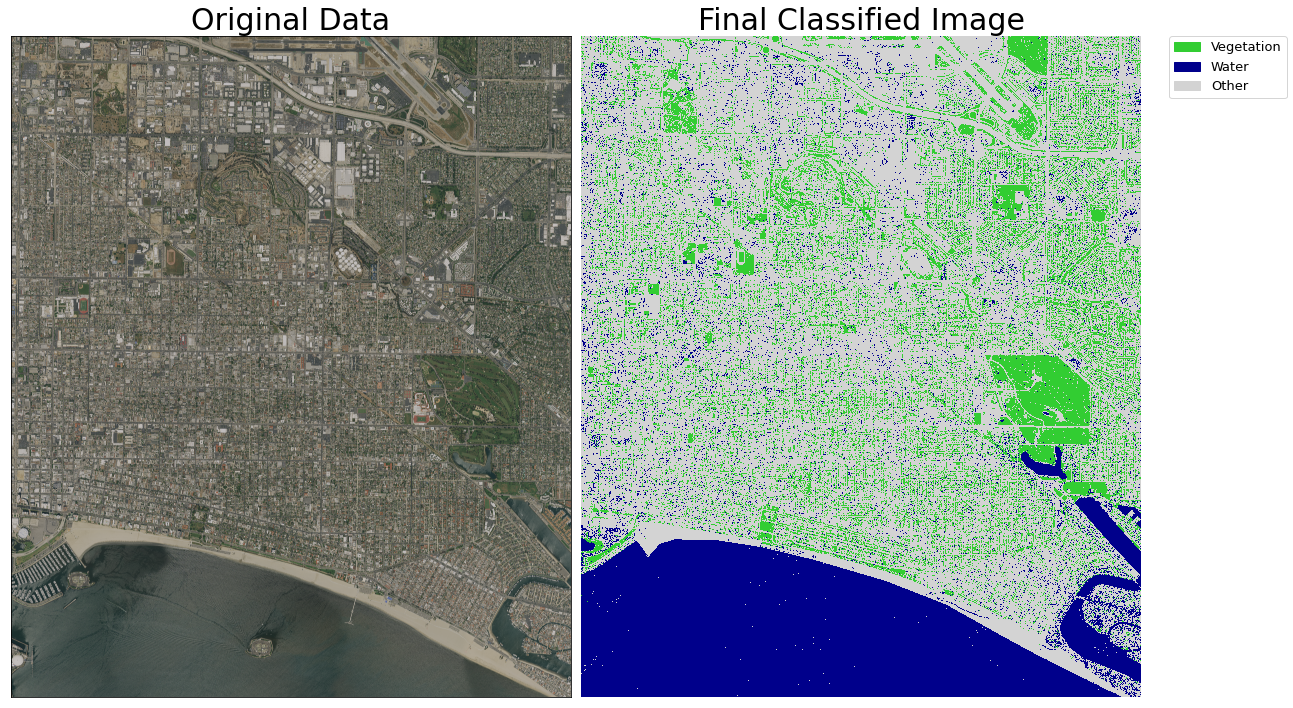

In [40]:
# Now plot the classmap next to the original image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

ep.plot_rgb(naip_tile.values,
            rgb=[0, 1, 2],
            ax=ax1)

im2 = ax2.imshow(class_prediction.transpose([1, 0]),
                 cmap=cmap,
                 interpolation='none')

ep.draw_legend(im_ax=im2,
               titles=training_classes)

ax1.set_title("Original Data", 
              fontsize=30)
ax2.set_title("Final Classified Image", 
              fontsize=30)
ax2.set_axis_off()

plt.tight_layout()
plt.show()

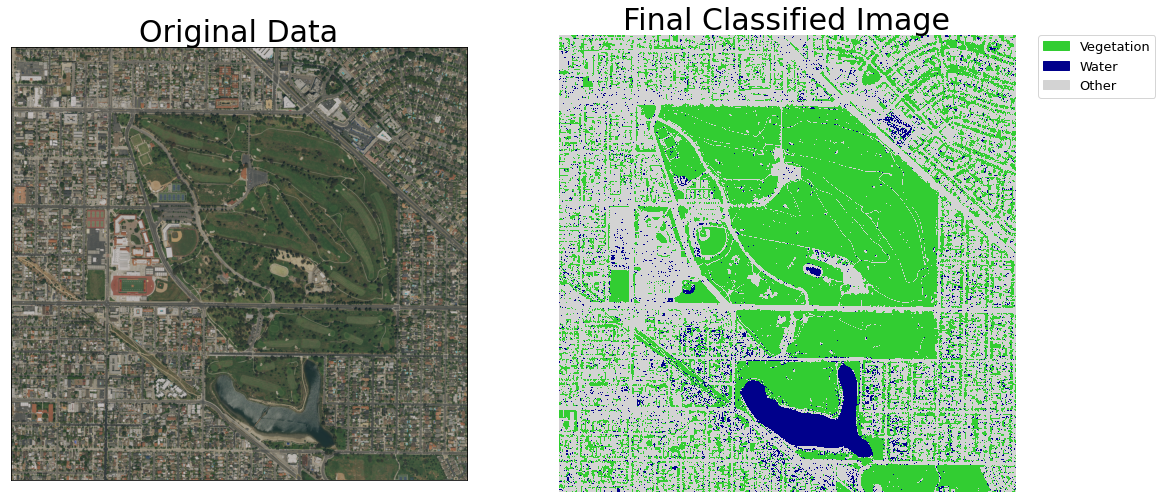

In [41]:
# Zoom in on both to see detail classmap
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))
ep.plot_rgb(naip_tile.values,
            rgb=[0, 1, 2],
            ax=ax1, 
            extent=tile_extent)
ax1.set_title("Original Data", 
              fontsize=30)
im2 = ax2.imshow(class_prediction.transpose([1, 0]),
                 cmap=cmap,
                 interpolation='none')


ep.draw_legend(im_ax=im2,
               titles=training_classes)
ax2.set_title("Final Classified Image", 
              fontsize=30)

ax1.set_xlim([393900, 395800])
ax1.set_ylim([3737100, 3738900])
ax2.set_xlim([7000, 10000])
ax2.set_ylim([8500, 5500])

ax2.set_axis_off()
plt.show()